## Necessary Imports

In [1217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from datetime import datetime, timedelta
import plotly.express as px
from scipy import stats

## Read and Prepare the CSV

In [1218]:
df = pd.read_csv("../Data/SQL_LHF.csv", index_col='MarketTradeDate')
df.index = pd.to_datetime(df.index)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.replace(-1000000000, np.nan, inplace=True)
df = df.iloc[::-1]
df["Switch"] = df["ContractDate"].shift(1, fill_value=df["ContractDate"].head(1)) != df["ContractDate"]
df = df[df.index > '1981-12-31']
df = df[df.index < '2024-01-01']
df.head()

,OpenPx,HighPx,LowPx,SettlementPx,Volume,OpenInterest,ContractDate,Switch
MarketTradeDate,,,,,,,,
1982-01-04,43.97,44.15,43.40,43.82,3043.0,8417.0,1982-02-01,False
1982-01-05,43.67,44.10,43.15,43.87,3087.0,8421.0,1982-02-01,False
1982-01-06,43.88,45.35,43.85,45.27,4447.0,8478.0,1982-02-01,False
1982-01-07,45.27,45.45,44.65,44.85,3613.0,8603.0,1982-02-01,False
1982-01-08,44.85,45.85,44.80,45.60,3406.0,8644.0,1982-02-01,False


In [1219]:
yahoo_df = pd.read_csv("../Data/YH_LHF.csv", index_col='Date')
yahoo_df.index = pd.to_datetime(yahoo_df.index)
yahoo_df = yahoo_df.loc[:, ~yahoo_df.columns.str.contains('^Unnamed')]
yahoo_df = yahoo_df.iloc[::-1]
df = df[df.index < '2024-01-01']

yahoo_df = yahoo_df.interpolate()  # Interpolates missing values linearly
yahoo_df = yahoo_df.dropna()       # Drops any remaining NA values

yahoo_df.head()

C:\Users\ldolvin\AppData\Local\Temp\ipykernel_59460\74760968.py:7: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-03-04,59.70,59.88,59.6,59.65,59.65,-
2002-03-05,59.15,59.15,58.7,58.80,58.80,-
2002-03-06,58.50,58.80,57.7,57.70,57.70,-
2002-03-07,58.20,58.60,58.0,58.40,58.40,-
2002-03-08,58.25,58.25,57.9,58.05,58.05,-


## EDA

In [1220]:
print(df['OpenPx'].isna().sum(), df['HighPx'].isna().sum(), df['LowPx'].isna().sum(), df['SettlementPx'].isna().sum(), df['Volume'].isna().sum(), df['OpenInterest'].isna().sum())

0 0 0 0 0 19


In [1221]:
# Creating an interactive plot
fig = go.Figure(data=[go.Scatter(x=df.index, y=df['SettlementPx'], mode='lines')])

# Update layout for a better visual appearance
fig.update_layout(
    title='Settlement Price Over Time',
    xaxis_title='Date',
    yaxis_title='Settlement Price',
    hovermode='closest'  # Show closest data point on hover
)

# Show the figure
fig.show()

In [1222]:
temp_df = pd.merge(yahoo_df, df, how='left', left_on='Date', right_index=True)
temp_df.head()

,Open,High,Low,Close,Adj Close,Volume_x,OpenPx,HighPx,LowPx,SettlementPx,Volume_y,OpenInterest,ContractDate,Switch
Date,,,,,,,,,,,,,,
2002-03-04,59.70,59.88,59.6,59.65,59.65,-,59.70,59.90,59.550,59.675,2808.0,16577.0,2002-04-01,False
2002-03-05,59.15,59.15,58.7,58.80,58.80,-,59.15,59.30,58.600,58.850,3937.0,16361.0,2002-04-01,False
2002-03-06,58.50,58.80,57.7,57.70,57.70,-,58.70,58.85,57.650,57.975,5997.0,15815.0,2002-04-01,False
2002-03-07,58.20,58.60,58.0,58.40,58.40,-,58.10,58.65,58.000,58.325,4427.0,15185.0,2002-04-01,False
2002-03-08,58.25,58.25,57.9,58.05,58.05,-,58.25,58.30,57.875,58.125,3441.0,14772.0,2002-04-01,False


In [1223]:
# Creating an interactive plot
fig = px.line(temp_df, x=temp_df.index, y=['Adj Close', 'SettlementPx'])

# Update layout for a better visual appearance
fig.update_layout(
    title='YH vs SQL Close Price Over Time',
    xaxis_title='Date',
    yaxis_title='Closes',
    hovermode='closest'  # Show closest data point on hover
)

# Show the figure
fig.show()

del temp_df

## Additive Model of Time Series Decomposition

Peak Dates:
1982-06-18
1983-06-15
1984-06-14
1985-06-03
1986-06-02
1987-06-01
1988-05-27
1989-05-26
1990-05-25
1991-05-24
1992-05-22
1993-05-24
1994-05-11
1995-05-10
1996-05-08
1997-05-08
1998-05-08
1999-05-10
2000-05-09
2001-05-09
2002-05-13
2003-05-14
2004-05-13
2005-05-16
2006-05-16
2007-05-17
2008-05-15
2009-05-15
2010-05-17
2011-05-16
2012-05-15
2013-05-15
2014-05-15
2015-05-15
2016-05-16
2017-05-16
2018-05-16
2019-05-16
2020-05-15
2021-05-17
2022-05-16
2023-05-02

Trough Dates:
1982-12-03
1983-12-02
1984-11-30
1985-11-18
1986-11-17
1987-11-16
1988-11-14
1989-11-13
1990-11-12
1991-11-11
1992-11-09
1993-11-09
1994-10-27
1995-10-26
1996-10-24
1997-10-24
1998-10-26
1999-10-26
2000-10-25
2001-10-29
2002-10-29
2003-10-30
2004-11-01
2005-11-01
2006-11-01
2007-11-02
2008-10-31
2009-11-02
2010-11-02
2011-11-01
2012-10-31
2013-10-31
2014-10-31
2015-11-02
2016-11-01
2017-11-01
2018-11-01
2019-11-01
2020-11-02
2021-11-02
2022-11-02
2023-10-19


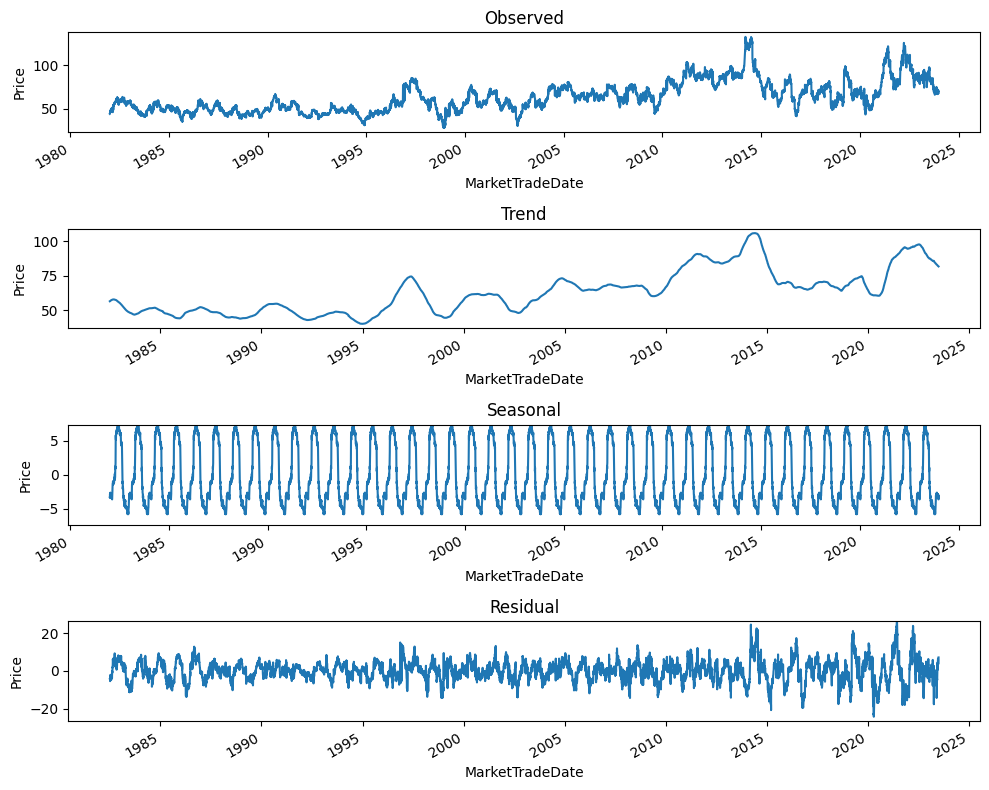

In [1224]:
result = seasonal_decompose(df['SettlementPx'], model='additive', period=252)

# Extract the seasonal component
seasonal = result.seasonal

# Initialize lists to store peak and trough dates
peak_dates = []
trough_dates = []

# Loop through each year in the data
for year in range(seasonal.index.year.min(), seasonal.index.year.max() + 1):
    # Extract the seasonal component for the current year
    yearly_seasonal = seasonal[seasonal.index.year == year]
    
    # Find peaks (local maxima) within the current year
    peaks, _ = find_peaks(yearly_seasonal)
    if peaks.size > 0:
        peak_date = yearly_seasonal.index[peaks[np.argmax(yearly_seasonal.iloc[peaks])]]
        peak_dates.append(peak_date)
    
    # Find troughs (local minima) within the current year
    troughs, _ = find_peaks(-yearly_seasonal)
    if troughs.size > 0:
        trough_date = yearly_seasonal.index[troughs[np.argmin(yearly_seasonal.iloc[troughs])]]
        trough_dates.append(trough_date)

# Print the dates
print("Peak Dates:")
for date in peak_dates:
    print(date.strftime('%Y-%m-%d'))

print("\nTrough Dates:")
for date in trough_dates:
    print(date.strftime('%Y-%m-%d'))
# Plotting with adjustments
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')

# Dynamic y-axis limits based on actual data ranges
seasonal_limit = max(abs(result.seasonal.min()), abs(result.seasonal.max()))
resid_limit = max(abs(result.resid.min()), abs(result.resid.max()))

# Adjusting the y-axis scale for seasonal and residual if necessary
axes[2].set_ylim(-seasonal_limit, seasonal_limit)  # Adjust to fit the seasonal data
axes[3].set_ylim(-resid_limit, resid_limit)  # Adjust to fit the residual data
axes[0].set_ylabel('Price')
axes[1].set_ylabel('Price')
axes[2].set_ylabel('Price')
axes[3].set_ylabel('Price')

plt.tight_layout()
plt.show()

In [1225]:
# Extract the seasonal component
seasonal = result.seasonal

# Initialize lists to store peak and trough dates
peak_dates = []
trough_dates = []

# Loop through each year in the data
for year in range(seasonal.index.year.min(), seasonal.index.year.max() + 1):
    # Extract the seasonal component for the current year
    yearly_seasonal = seasonal[seasonal.index.year == year]
    
    # Find peaks (local maxima) within the current year
    peaks, _ = find_peaks(yearly_seasonal)
    if peaks.size > 0:
        peak_date = yearly_seasonal.index[peaks[np.argmax(yearly_seasonal.iloc[peaks])]]
        peak_dates.append(peak_date)
    
    # Find troughs (local minima) within the current year
    troughs, _ = find_peaks(-yearly_seasonal)
    if troughs.size > 0:
        trough_date = yearly_seasonal.index[troughs[np.argmin(yearly_seasonal.iloc[troughs])]]
        trough_dates.append(trough_date)

# Convert dates to day of year
peak_days = [date.timetuple().tm_yday for date in peak_dates]
trough_days = [date.timetuple().tm_yday for date in trough_dates]

# Calculate average day of year
avg_peak_day = int(np.mean(peak_days))
avg_trough_day = int(np.mean(trough_days))

# Convert average day of year back to a date (choosing a non-leap year for consistency)
reference_year = 2000  # Non-leap year to avoid complications with Feb 29
avg_peak_date = datetime(reference_year, 1, 1) + timedelta(days=avg_peak_day - 1)
avg_trough_date = datetime(reference_year, 1, 1) + timedelta(days=avg_trough_day - 1)

# Print the average dates
print("Average Peak Date:", avg_peak_date.strftime('%Y-%m-%d'))
print("Average Trough Date:", avg_trough_date.strftime('%Y-%m-%d'))

Average Peak Date: 2000-05-17
Average Trough Date: 2000-11-03


## Backtest the Strategy

In [1226]:
def backtest(df, buy, sell):
    df['pct_change'] = df['SettlementPx'].pct_change()
    df = df.iloc[1:, :]
    return_list =[]
    date_list = []

    for i, row in df.iterrows():
        if row['Switch'] == True:
            continue
        # Extract the month and day from the index
        temp = datetime(year=1904, month=i.month, day=i.day)
        # Check if the date is between the start and end dates
        if sell <= temp < buy:
            return_list.append(-1*row['pct_change'])
            date_list.append(i)
        else:
            return_list.append(row['pct_change'])
            date_list.append(i)
    
    return_df = pd.DataFrame({'date': date_list, 'return': return_list}, columns=['date', 'return'])
    return_df.set_index('date')
 
    return return_df

In [1227]:
sell = datetime(year=1904, month=avg_peak_date.month, day=avg_peak_date.day)
buy = datetime(year=1904, month=avg_trough_date.month, day=avg_trough_date.day)
return_df = backtest(df, buy, sell)
return_df.head()

,date,return
0,1982-01-05,0.001141
1,1982-01-06,0.031912
2,1982-01-07,-0.009278
3,1982-01-08,0.016722
4,1982-01-11,-0.005044


In [1228]:
total_return = 1
for i, row in return_df.iterrows():
    total_return *= (1 + row['return'])
total_return = (total_return - 1)
print(f"Total Return: {'%.2f' % (total_return*100)}%")

Total Return: -57.54%


In [1229]:
yearly_avg = ((total_return + 1)**(1/42))-1
print(f"Annual Return: {'%.2f' % (yearly_avg*100)}%")

Annual Return: -2.02%


#### Year By Year Analysis

In [1230]:
return_df.set_index('date', inplace=True)
annual_data = return_df.groupby(pd.Grouper(freq='YE'))
annual_returns = annual_data['return'].apply(lambda x: (1 + x).prod() - 1)
annual_std_dev = annual_data['return'].std()
annual_sharpe = (annual_returns - 0.01616) / annual_std_dev
annual_summary = pd.DataFrame({'Annual Returns': annual_returns, 'Annual Std Dev': annual_std_dev, 'Annual Sharpe': annual_sharpe})

total_return = (1 + annual_summary['Annual Returns']).prod()
print(f"Total Return: {'%.2f' % ((total_return-1)*100)}%")
print()

print(f"Average Return: {'%.2f' % ((stats.gmean(annual_summary['Annual Returns'] + 1)-1)*100)}%, Average Std Dev: {'%.4f' % annual_summary['Annual Std Dev'].mean()}, Average Sharpe: {'%.2f' % annual_summary['Annual Sharpe'].mean()}")
print()

annual_summary.head(45)

Total Return: -57.54%

Average Return: -2.02%, Average Std Dev: 0.0153, Average Sharpe: 0.63



,Annual Returns,Annual Std Dev,Annual Sharpe
date,,,
1982-12-31,0.369569,0.015586,22.674144
1983-12-31,-0.081917,0.012941,-7.578909
1984-12-31,0.207967,0.011150,17.202924
1985-12-31,-0.184602,0.013797,-14.551189
1986-12-31,-0.256153,0.015032,-18.114980
1987-12-31,0.100768,0.012808,6.606054
1988-12-31,0.509299,0.014073,35.042058
1989-12-31,-0.183915,0.010873,-18.401204
1990-12-31,0.299054,0.011177,25.309242
